# Simulation of binary classification

I'm trying to figure out the limits of ROC curve analysis and also precision-recall (PR) curves. I want to simulate some data and see how an unskilled classifier performs. 

First let's define functions to simulate binary data and an unskilled classifier.

In [1]:
import numpy as np

def simulate_targets(n = 100, p = 0.5):
    """Simulate n binary targets with proportion p of positive class"""
    y = np.zeros(shape = n, dtype = int)
    idx_flip = np.random.choice(n, size = int(p*n), replace = False)
    y[idx_flip] = 1
    return y

def unskilled_classifier(y):
    """Classifier that predicts positive class with p = 0.5"""
    y_pred = np.random.choice(np.unique(y), size = len(y), replace = True)
    return y_pred

We can simulate true data with a given probability for the positive class:

In [2]:
n = 100
p = 0.5

y_true = simulate_targets(n = n, p = p)
print(y_true)

[1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0
 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1
 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0]


We can then generate predicted labels using the unskilled classifier, which just predicts either class with 50% probability.

In [3]:
y_pred = unskilled_classifier(y = y_true)
y_pred

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])

With our true and predicted data, we can compute the AUC for the ROC curve:

In [4]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_true, y_pred)
print('{:.2f}'.format(auc))

0.51


For this fixed set of true labels, the predicted labels are random, so let's re-run the classifier a number of times to characterize the distribution of AUC values.

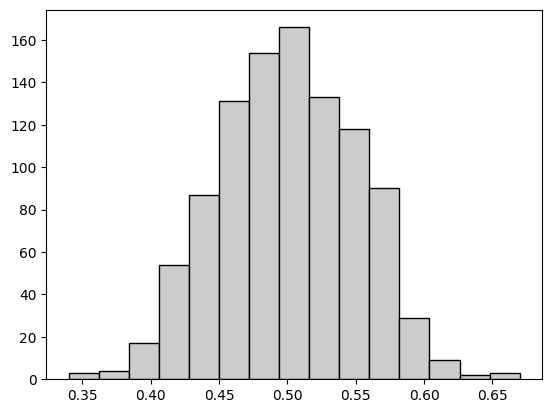

In [5]:
nsim = 1000

auc = np.zeros(nsim)
for i in range(len(auc)):
    y_pred = unskilled_classifier(y = y_true)
    auc[i] = roc_auc_score(y_true, y_pred)

import matplotlib.pyplot as plt

_  = plt.hist(auc, bins = 15, color = '0.8', edgecolor = 'black')

Let's write a function to do all of this

In [6]:
def simulate_ROC_AUC(p = 0.5, n = 100, B = 1000):

    # Simulate true labels
    y_true = simulate_targets(p = p, n = n)

    # Compute the AUC B times using the unskilled classifier
    auc = np.zeros(B)
    for i in range(len(auc)):
        y_pred = unskilled_classifier(y = y_true)
        auc[i] = roc_auc_score(y_true, y_pred)

    return auc

Now let's simulate the AUC distributions for a range of true positive class probabilities. 

In [7]:
n = 100 # Sample size
p_range = np.arange(0.1, 1.0, 0.1) # Positive class probabilities

B = 2000 # Number of simulations

# Generate AUC distributions
auc_data = []
for i, p in enumerate(p_range):
    auc = simulate_ROC_AUC(p = p, n = n, B = B)
    auc_data.append(auc)

Visualize the results:

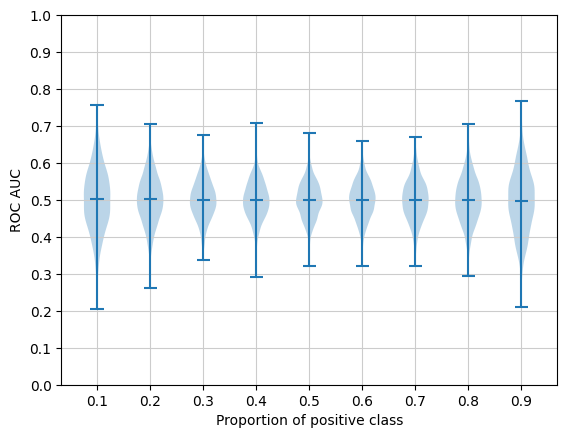

In [20]:
fig, ax = plt.subplots()

ax.violinplot(auc_data, showmeans = True)
ax.set_ylim([0, 1])
ax.set_xticks([y + 1 for y in range(len(auc_data))],
             labels = ['{:.1f}'.format(p) for p in p_range])
ax.set_yticks(np.arange(0,1.1,0.1));
ax.set_ylabel("ROC AUC")
ax.set_xlabel("Proportion of positive class")
ax.grid(color = '0.8')

I may have done this wrong. The ROC curve and AUC need to take class probabilities, not class labels.

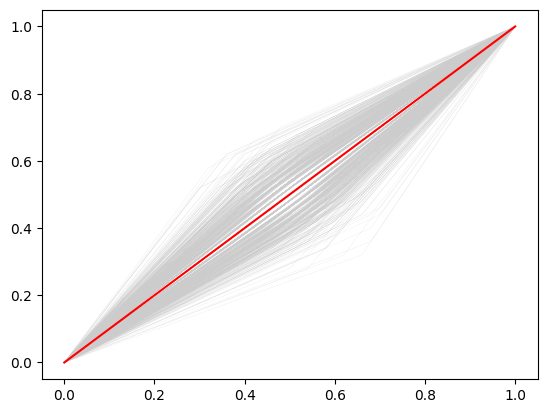

In [9]:
from sklearn.metrics import roc_curve

# Parameters for the true labels
p = 0.5
n = 100

# Simulate true labels
y_true = simulate_targets(p = p, n = n)

# Unskilled class probabilities (just a vector of 0.5)
y_pred_proba = np.repeat(0.5, n)

# Compute ROC curve using the probabilities
fpr_proba, tpr_proba, thresholds = roc_curve(y_true, y_pred_proba)

fig, ax = plt.subplots()

# Generate 1000 ROC curves using the predicted labels
# Note: These labels are being interpreted as probabilities
B = 1000
for b in range(B):
    y_pred_labels = unskilled_classifier(y = y_true)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_labels)
    ax.plot(fpr, tpr, color = '0.8', lw = 0.1)

# Plot the true unskilled ROC curve
ax.plot(fpr_proba, tpr_proba, color = 'red');

What happens if we vary over p?

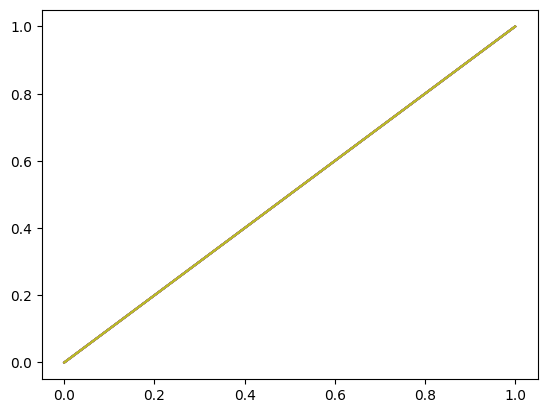

In [10]:
n = 100 # Sample size
p_range = np.arange(0.1, 1.0, 0.1) # Positive class probabilities

# Unskilled probabilities
y_pred_proba = np.repeat(0.5, n)

fig, ax = plt.subplots()

# for i, p in enumerate(p_range):
for p in p_range:
    
    # Simulate true labels
    y_true = simulate_targets(p = p, n = n)
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    ax.plot(fpr, tpr);

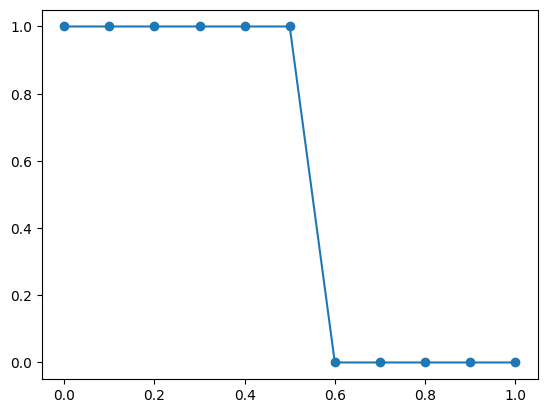

In [11]:
n = 100
p = 0.2

# Simulate true labels
y_true = simulate_targets(p = p, n = n)
y_true = y_true.astype(bool)

y_pred_proba = np.repeat(0.5, n)

# Total number of positives and negatives
P = sum(y_true)
N = n - P

thresholds = np.arange(0., 1.1, 0.1)
tpr = np.zeros(len(thresholds))
fpr = np.zeros(len(thresholds))
for i, thresh in enumerate(thresholds):
    y_pred = y_pred_proba >= thresh
    tpr[i] = sum(y_true & y_pred)/P
    fpr[i] = sum(y_pred & ~y_true)/N

fig, ax = plt.subplots()
ax.plot(thresholds, tpr);
ax.scatter(thresholds, tpr);

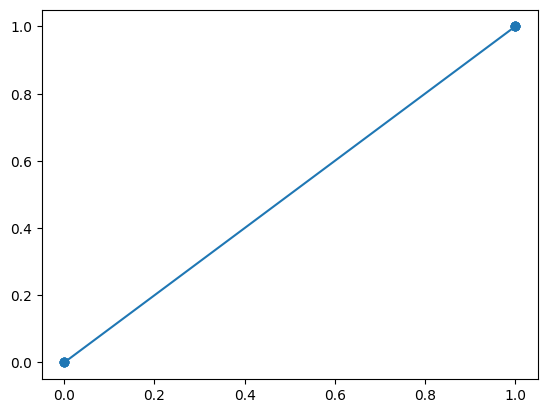

In [12]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr);
ax.scatter(fpr, tpr);

Maybe the best thing to do is to simulate a logistic regression. We can vary the positive class proportion by varying the bias of the model. Here are examples of the logistic curves with different intercepts. The weight is fixed to a value of 1.

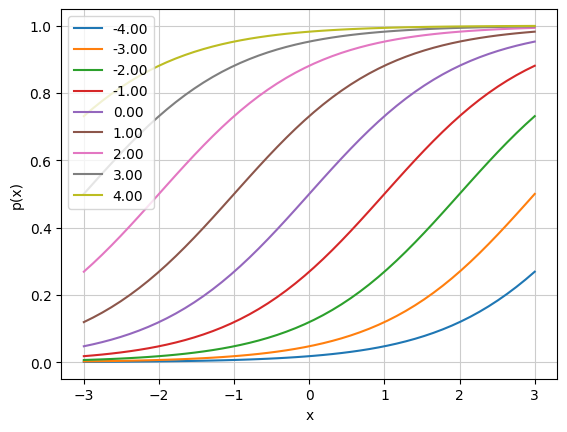

In [152]:
# Range of x values
x = np.linspace(-3, 3)

fig, ax = plt.subplots()

# Fixed weight
w = 1

# Iterate over bias values
b = np.arange(-4, 5)
for bi in b:
    p = np.exp(x+bi)/(1 + np.exp(x+bi))
    ax.plot(x, p, label = '{:.2f}'.format(bi))

ax.legend();
ax.set_xlabel("x");
ax.set_ylabel("p(x)");
ax.grid(color = '0.8')
ax.set_axisbelow(True)

Notice how the bias (intercept) term moves the sigmoid left or right. We can use this model to simulate binary data. Remember that this isn't a probability distribution. The $p$ refers to the positive class probability in a binomial distribution. The way to think of this is that there's a separate binomial distribution at each value of $x$. To simulate data, we can first simulate $x$ values from a standard normal distribution. We use the logistic function to generate the corresponding values for $p$. Then using those values, we simulate binary targets using the binomial distribution. Here's how that works for a logistic model with a bias of 0 and a weight of 1.

In [14]:
# Set the bias and weight value
b = 0
w = 1

# Sample size
n = 100

# Simulate the inputs from a Gaussian
x = np.random.normal(size = n)

# Compute the positive class probabilities using the logistic function
p = np.exp(w*x+b)/(1 + np.exp(w*x+b))

# Predict a binary target for each value of x, using the probability model
# Note how we're drawing a single sample for each value of p
y = np.random.binomial(n = 1, p = p, size = len(p))

In the current draw, the proportion of the positive class over the entire input sample draw is as follows:

In [15]:
sum(y)/len(y)

0.43

Now, because the targets are themselves stochastic, the class proportions will vary in each draw, even if the inputs are fixed. So to get a sense of the range of the class proportions, we want to run this multiple times for each bias value. 

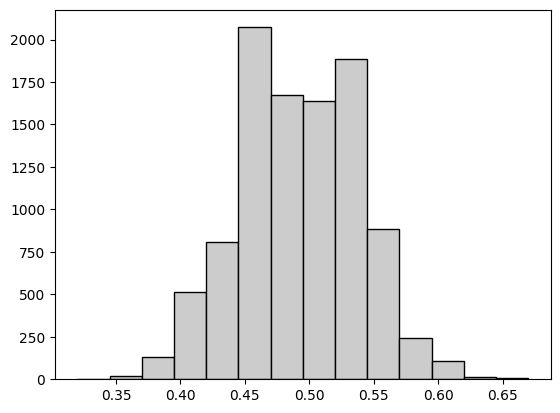

In [16]:
B = 10000
y_draws = np.zeros(shape = (n, B))
for j in range(B):
    y_draws[:,j] = np.random.binomial(n = 1, p = p, size = len(p))

pos_prop = np.sum(y_draws, axis = 0)/n

_  = plt.hist(pos_prop, bins = 14, color = '0.8', edgecolor = 'black')

For $b = 0$ and $w = 1$, the distribution of class proportion is centered around 0.5. (Are we coming up against the central limit theorem? Probably.)

What's the next step? We vary $b$ and recompute these distributions? 

In [39]:
def simulate_logreg_targets(x, b = 0, w = 1):

    # Compute the positive class probabilities using the logistic function
    p = np.exp(w*x+b)/(1 + np.exp(w*x+b))

    # Predict a binary target for each value of x, using the probability model
    # Note how we're drawing a single sample for each value of p
    y = np.random.binomial(n = 1, p = p, size = len(p))

    return y, p


def simulate_logreg_props(x, b = 0, w = 1, B = 10000):

    y_draws = np.zeros(shape = (len(x), B))
    for j in range(B):
        y_draws[:,j], p = simulate_logreg_targets(x = x, b = b, w = w)

    props = np.sum(y_draws, axis = 0)/len(x)

    return props

# Set the bias and weight value
b = 0
w = 1

# Sample size
n = 100

# Simulate the inputs from a Gaussian
x = np.random.normal(size = n)

list_props = []
b_range = np.arange(-4, 5)
for b in b_range:
    props = simulate_logreg_props(x = x, b = b)
    list_props.append(props)

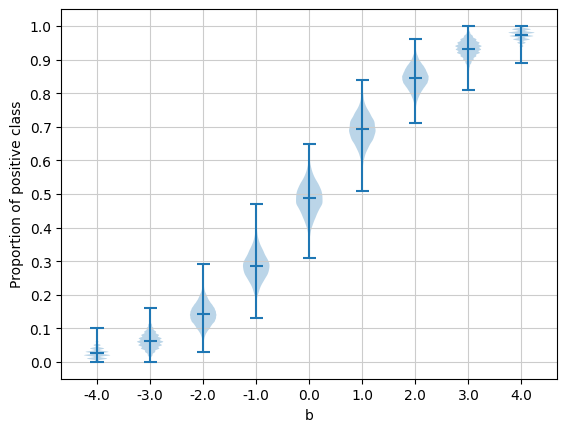

In [40]:
fig, ax = plt.subplots()

ax.violinplot(list_props, showmeans = True)
ax.set_xticks([y + 1 for y in range(len(auc_data))],
             labels = ['{:.1f}'.format(b) for b in b_range])
ax.set_yticks(np.arange(0,1.1,0.1));
ax.set_xlabel("b")
ax.set_ylabel("Proportion of positive class")
ax.grid(color = '0.8')

In [146]:
b = 0
B = 1000

prop_list = []
auc_list = []
b_range = np.arange(-4, 5)
for b in b_range:

    prop_array = np.zeros(B)
    auc_array = np.zeros(B)
    for i in range(B):
        y, p = simulate_logreg_targets(x = x, b = b)
        prop_array[i] = sum(y)/len(y)
        if prop_array[i] in [0.0, 1.0]:
            auc_array[i] = np.nan
        else:
            auc_array[i] = roc_auc_score(y, p)

    not_nan = ~np.isnan(auc_array)
    auc_array = auc_array[not_nan]
    prop_array = prop_array[not_nan]
    
    prop_list.append(prop_array)
    auc_list.append(auc_array)

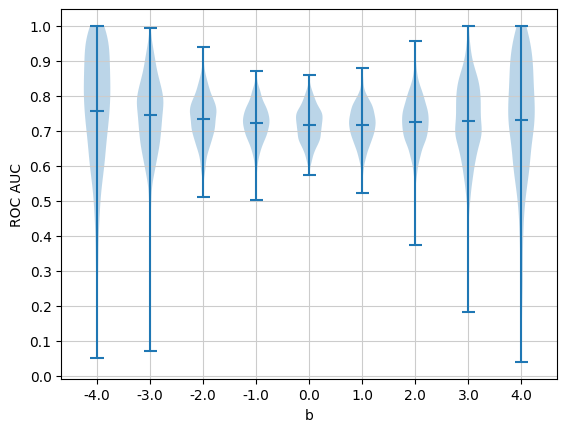

In [147]:
fig, ax = plt.subplots()

ax.violinplot(auc_list, showmeans = True)
ax.set_xticks([y + 1 for y in range(len(auc_data))],
             labels = ['{:.1f}'.format(b) for b in b_range])
ax.set_yticks(np.arange(0,1.1,0.1));
ax.set_xlabel("b")
ax.set_ylabel("ROC AUC")
ax.grid(color = '0.8')

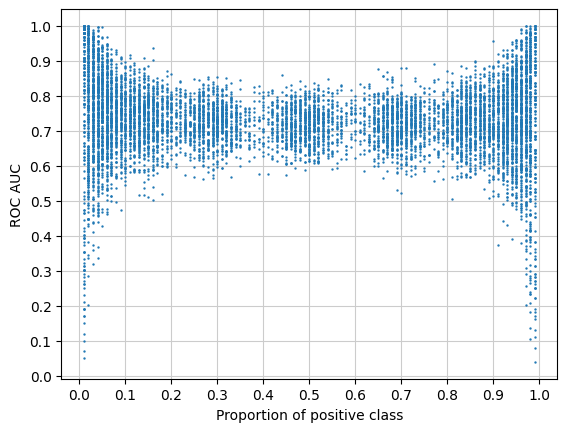

In [150]:
fig, ax = plt.subplots()

ax.scatter(np.concatenate(prop_list), np.concatenate(auc_list), s = 0.5)
ax.set_xlabel("Proportion of positive class")
ax.set_ylabel("ROC AUC")
ax.set_xticks(np.arange(0,1.1,0.1));
ax.set_yticks(np.arange(0,1.1,0.1));
ax.grid(color = '0.8')
ax.set_axisbelow(True)

# Precision-recall curves

What do these curves look like for an unskilled classifier?

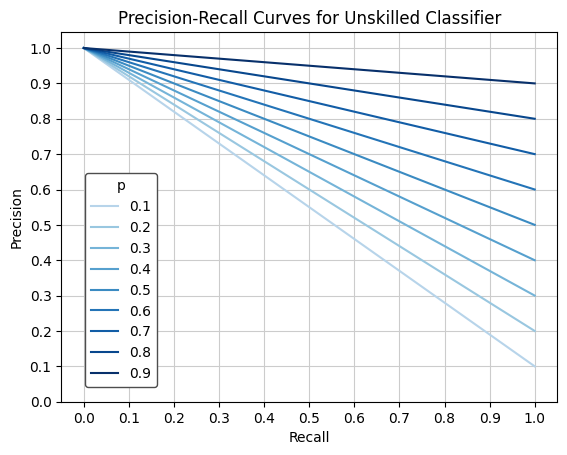

In [246]:
from sklearn.metrics import precision_recall_curve

# Sample size
n = 100

p_model = np.repeat(0.5, len(y))

fig, ax = plt.subplots()

# Range of positive class proportions
p_range = np.arange(0.1, 1.0, 0.1)

# Colour palette for each p
palette = plt.get_cmap('Blues')(np.linspace(0.3, 1.0, len(p_range)))

# Iterate over p
for i, p in enumerate(p_range):
    y = simulate_targets(n = n, p = p)
    precision, recall, thresholds = precision_recall_curve(y, p_model)
    ax.plot(recall, precision, label = '{:.1f}'.format(p), color = palette[i])

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xticks(np.arange(0.0, 1.1, 0.1))
ax.set_yticks(np.arange(0.0, 1.1, 0.1))
ax.grid(color = '0.8')
ax.set_axisbelow(True)
ax.set_title('Precision-Recall Curves for Unskilled Classifier');
fig.legend(loc = (0.15, 0.15), title = "p", framealpha = 1.0, edgecolor = "0.3");